In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [2]:
def iqr_remove_outliers(df, column):
    Q1, Q3 = df[column].quantile(0.25), df[column].quantile(0.75)
    lower_bound, upper_bound = Q1 - 1.5 * (Q3 - Q1), Q3 + 1.5 * (Q3 - Q1)
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return df.drop(df[outliers].index)

def std_remove_outliers(df, column):
    outliers = (df[column] - df[column].mean()).abs() > 3 * df[column].std()
    return df.drop(df[outliers].index)

def remove_outliers(df, column):
    if abs(df[column].skew()) > 0.75:
        return iqr_remove_outliers(df, column)
    return std_remove_outliers(df, column)

In [6]:
df = pd.read_csv("Loan_Default.csv")
df.drop(["year"], axis = 1, inplace = True)

In [23]:
numerical_variables = df._get_numeric_data().columns
categorical_variables = ["ID"] + [column for column in df.columns if column not in numerical_variables] + ["Status"]

df_categorical = df[categorical_variables]
df_numerical = df[numerical_variables]

In [8]:
df_categorical.isna().sum()

ID                              0
loan_limit                   3344
Gender                          0
approv_in_adv                 908
loan_type                       0
loan_purpose                  134
Credit_Worthiness               0
open_credit                     0
business_or_commercial          0
Neg_ammortization             121
interest_only                   0
lump_sum_payment                0
construction_type               0
occupancy_type                  0
Secured_by                      0
total_units                     0
credit_type                     0
co-applicant_credit_type        0
age                           200
submission_of_application     200
Region                          0
Security_Type                   0
Status                          0
dtype: int64

In [24]:
# Odstranimo vrstice, ki vsebujejo NaN glede na to, da jih je proporcionalno zelo malo
df_categorical = df_categorical.dropna(
    subset=["loan_limit", "approv_in_adv", "loan_purpose", "Neg_ammortization", "age", "submission_of_application"]
)

In [25]:
df_categorical["Status"].value_counts()

Status
0    108713
1     35270
Name: count, dtype: int64

In [26]:
# Spremenimo categorične vrednosti v numerične
encoder = LabelEncoder()
for column in df_categorical.columns:
    if column == "ID" or column == "Status":
        pass
    else:
        df_categorical[column] = encoder.fit_transform(df_categorical[column])

<Axes: >

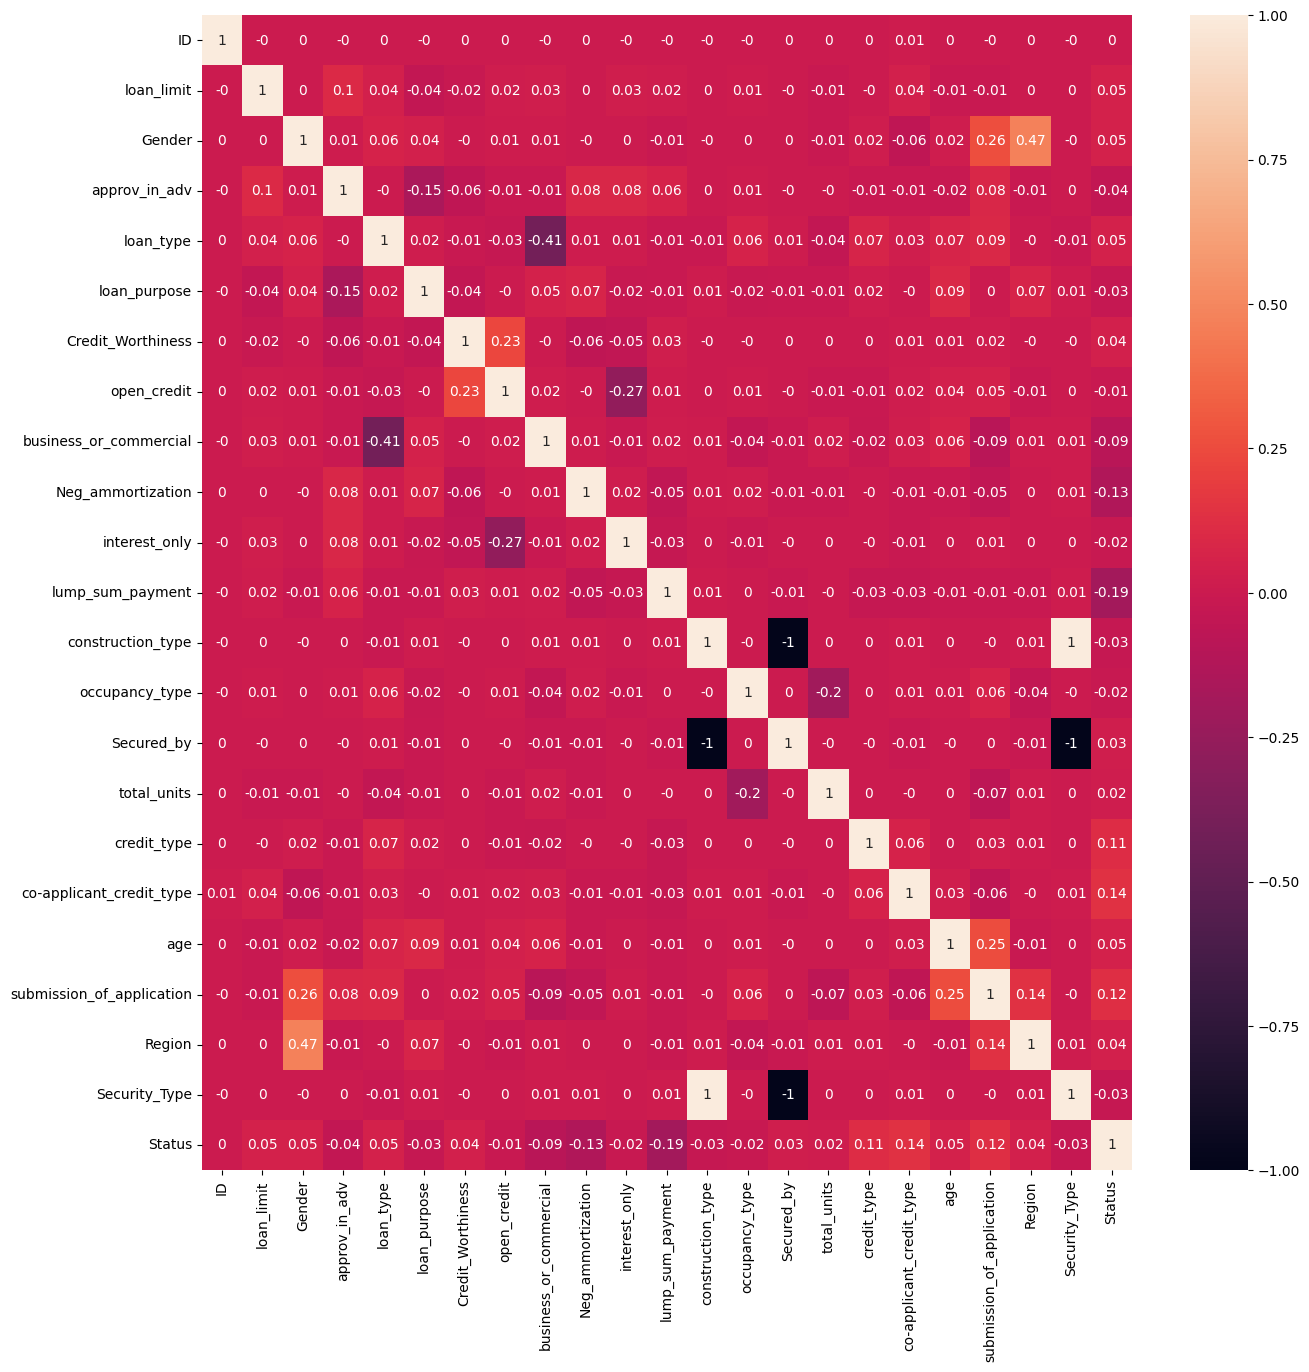

In [13]:
cat_corr = np.round(df_categorical.corr(), 2)
plt.figure(figsize=(15, 15))
sns.heatmap(cat_corr, annot=True)

In [27]:
df_categorical.drop(["Security_Type", "construction_type"], axis = 1, inplace = True)

In [28]:
# Uvedemo novo spremenljivko rate 
df_numerical["rate"] = df_numerical["rate_of_interest"] + df_numerical["Interest_rate_spread"]
df_numerical.drop(["rate_of_interest", "Interest_rate_spread"], axis = 1, inplace = True)

C:\Users\uporabnik\AppData\Local\Temp\ipykernel_14416\592117228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical["rate"] = df_numerical["rate_of_interest"] + df_numerical["Interest_rate_spread"]
C:\Users\uporabnik\AppData\Local\Temp\ipykernel_14416\592117228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.drop(["rate_of_interest", "Interest_rate_spread"], axis = 1, inplace = True)


In [29]:
# Odstranimo LTV, saj je samo razmerje loan_amount / property_value
df_numerical.drop("LTV", axis = 1, inplace = True)

C:\Users\uporabnik\AppData\Local\Temp\ipykernel_14416\2020733759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.drop("LTV", axis = 1, inplace = True)


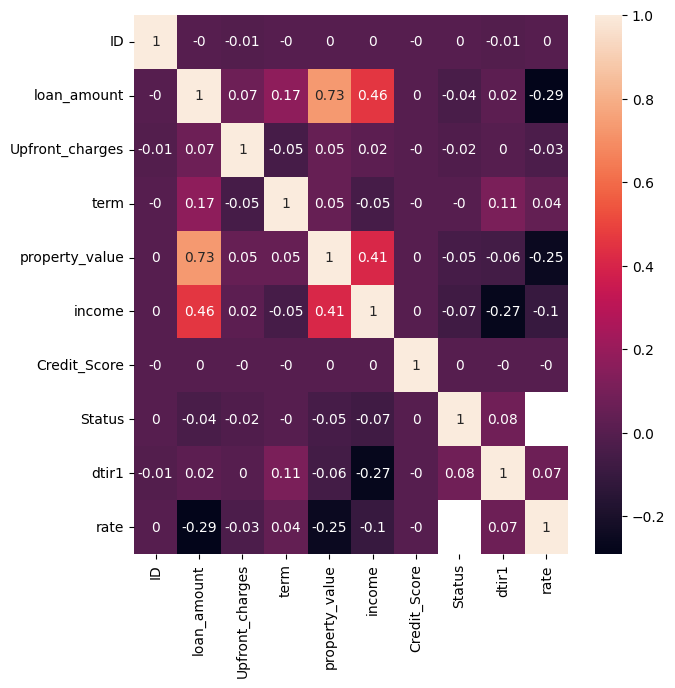

In [17]:
numercial_corr = np.round(df_numerical.corr(), 2)
plt.figure(figsize=(7, 7))
sns.heatmap(numercial_corr, annot = True)
plt.show()

In [30]:
# Odstranimo Credit_Score saj je porazdeljen enakomerno in nekorelirean z ostalimi
df_numerical.drop("Credit_Score", axis = 1, inplace = True)
df_numerical.drop("term", axis = 1, inplace = True)

C:\Users\uporabnik\AppData\Local\Temp\ipykernel_14416\2881230562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.drop("Credit_Score", axis = 1, inplace = True)


In [31]:
knn_imputer = KNNImputer(n_neighbors=3)
imputed_df = pd.DataFrame(knn_imputer.fit_transform(df_numerical.iloc[:, 1:]))
imputed_df.columns = df_numerical.columns[1:]
imputed_df["ID"] = df_numerical.reset_index()["ID"]

In [65]:
imputed_df = iqr_remove_outliers(imputed_df, "loan_amount")
imputed_df = remove_outliers(imputed_df, "rate")

In [66]:
for var in imputed_df.columns:
    if var == "Status" or var == "ID":
        continue
    if var in ["rate", "loan_amount", "dtir1"]:
        scaler = StandardScaler().fit(imputed_df[[var]])
        imputed_df[[var]] = scaler.transform(imputed_df[[var]])
    else:
        scaler = RobustScaler().fit(imputed_df[[var]])
        imputed_df[[var]]= scaler.transform(imputed_df[[var]])
        

In [67]:
data = pd.merge(df_categorical, imputed_df, on='ID', how='inner')
data.drop(["ID","Status_y"] , axis = 1, inplace = True)
data.rename(columns={'Status_x': 'Target'}, inplace=True)

In [68]:
X = data[data.columns.difference(["Target"])]
y = data["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [79]:
rus = RandomUnderSampler(random_state=9)
tl = TomekLinks()
sm = SMOTE(random_state=9)
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy="majority"))

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

sample = {
    "rus": [X_train_rus, y_train_rus],
    "tl": [X_train_tl, y_train_tl],
    "sm": [X_train_sm, y_train_sm],
    "smt": [X_train_smt, y_train_smt]
}

In [80]:
# modeli
lr = LogisticRegression(max_iter=1000)
kn = KNeighborsClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
bc = BaggingClassifier()
xgb = XGBClassifier()

models = [lr, kn, rf, dt, et, bc, xgb]

In [81]:
for model in models:
    print("MODEL:", model)
    for key, value in sample.items():
        model.fit(value[0], value[1])
        y_pred = model.predict(X_test)
        cr = metrics.classification_report(y_pred = y_pred, y_true = y_test, output_dict = True)
        print(key, cr["1"])
    print("")

MODEL: LogisticRegression(max_iter=1000)
rus {'precision': 0.4632018209408194, 'recall': 0.7091621896326412, 'f1-score': 0.5603809305260742, 'support': 6887.0}
tl {'precision': 0.7041577825159915, 'recall': 0.38362131552199796, 'f1-score': 0.496663220227465, 'support': 6887.0}
sm {'precision': 0.46298309775625185, 'recall': 0.6801219689269639, 'f1-score': 0.550929193131028, 'support': 6887.0}
smt {'precision': 0.46302124311565696, 'recall': 0.6836067954116452, 'f1-score': 0.5520961594840222, 'support': 6887.0}

MODEL: KNeighborsClassifier()
rus {'precision': 0.663050334300492, 'recall': 0.7631770001452011, 'f1-score': 0.7095990279465371, 'support': 6887.0}
tl {'precision': 0.8808870116156283, 'recall': 0.6056338028169014, 'f1-score': 0.7177766305283084, 'support': 6887.0}
sm {'precision': 0.6651694045174538, 'recall': 0.7525773195876289, 'f1-score': 0.7061788950200968, 'support': 6887.0}
smt {'precision': 0.6636062229023209, 'recall': 0.755626542761725, 'f1-score': 0.7066331726525902, 

In [95]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring="recall", n_jobs=-1)
    clf_grid.fit(X_train, y_train)
    print("Best hyperparameters:\n", clf_grid.best_params_)
    return clf_grid.best_estimator_

In [96]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200], 
    'min_child_weight': [1, 5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0],
    'gamma': [0, 1],
}

model = XGBClassifier()
optimal_model = tune_clf_hyperparameters(model, param_grid, X_train_rus, y_train_rus)

c:\Users\uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters:
 {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}


In [97]:
optimal_model.fit(X_train_rus, y_train_rus)
y_pred = optimal_model.predict(X_test)
cr = metrics.classification_report(y_pred = y_pred, y_true = y_test, output_dict = True)
print(cr["1"])

{'precision': 0.7866011381272633, 'recall': 0.8831131116596486, 'f1-score': 0.8320678568985567, 'support': 6887.0}


In [98]:
import torch
import torch.nn as nn
import torchvision.transforms as transform
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [106]:
train_set = TensorDataset(torch.tensor(X_train_sm.to_numpy(), dtype=torch.float32),
                          torch.tensor(y_train_sm.to_numpy().reshape(-1, 1), dtype=torch.float32)
                          )
test_set = TensorDataset(torch.tensor(X_test.to_numpy(), dtype=torch.float32),
                          torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)
                          )

batch_size = 32

loader = {
    "train" : DataLoader(train_set, batch_size = batch_size, shuffle = True),
    "test" : DataLoader(test_set, batch_size = batch_size, shuffle = True)
}

In [113]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(25, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 10)
        self.relu = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCELoss()

In [111]:
def train(epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        with tqdm(total=len(loader["train"])*batch_size, desc=f'Training - Epoch: {epoch + 1}/{epochs}', unit='chunks') as prog_bar:
            for i, data in enumerate(loader["train"], 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.detach().item()
                prog_bar.set_postfix(**{'loss': (running_loss) / (i+1)})
                prog_bar.update(batch_size)
    print('Finished Training') 
    
def test():
    model.eval()
    all_preds = []
    all_labels = []
    counter = 0
    threshold = 0.5
    with torch.no_grad():
        with tqdm(total=len(loader["test"])*batch_size, desc=f'Testing', unit='chunks') as prog_bar:
            for i, data in enumerate(loader["test"], 0):
                inputs, labels = data
                output = model(inputs)
                preds = (output.squeeze() > threshold).float()
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())
                prog_bar.update(batch_size)
                counter += 1
    
    print(metrics.classification_report(y_pred=all_labels, y_true=all_preds))
    cm = metrics.confusion_matrix(y_pred=all_labels, y_true=all_preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

Training - Epoch: 3/3: 100%|██████████| 171712/171712 [00:19<00:00, 9036.89chunks/s, loss=0.273] 


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 28352/28352 [00:00<00:00, 70778.82chunks/s]


              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     20394
         1.0       0.84      0.72      0.78      7956

    accuracy                           0.88     28350
   macro avg       0.87      0.83      0.85     28350
weighted avg       0.88      0.88      0.88     28350



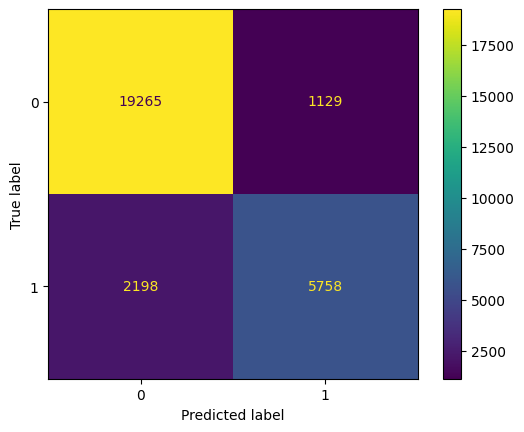

In [114]:
train(3)
print()

print("Accuracy on the test set after training the model")
test()